In [20]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def load_data():
    """Load data from the CSV files referundum/regions/departments."""
    referendum = pd.read_csv('data/referendum.csv',
                             sep=';')
    regions = pd.read_csv('data/regions.csv')
    departments = pd.read_csv('data/departments.csv')

    return referendum, regions, departments

In [3]:
referendum, regions, departments = load_data()

regions.head()

,id,code,name,slug
0,1,01,Guadeloupe,guadeloupe
1,2,02,Martinique,martinique
2,3,03,Guyane,guyane
3,4,04,La Réunion,la reunion
4,5,06,Mayotte,mayotte


In [4]:

departments.head()

,id,region_code,code,name,slug
0,1,84,01,Ain,ain
1,2,32,02,Aisne,aisne
2,3,84,03,Allier,allier
3,4,93,04,Alpes-de-Haute-Provence,alpes de haute provence
4,5,93,05,Hautes-Alpes,hautes alpes


In [5]:
def merge_regions_and_departments(regions, departments):
    """Merge regions and departments in one DataFrame.

    The columns in the final DataFrame should be:
    ['code_reg', 'name_reg', 'code_dep', 'name_dep']
    """
    df_merge = pd.merge(departments, regions, how='inner', 
                        left_on='region_code', right_on='code', 
                        suffixes= ('_dep', '_reg'))

    return df_merge.drop(['id_reg', 'slug_reg', 'id_dep', 'region_code', 'slug_dep'], axis=1)

In [6]:
regions_and_departments = merge_regions_and_departments(regions, departments)

In [7]:
referendum.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36791 entries, 0 to 36790
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Department code  36791 non-null  object
 1   Department name  36791 non-null  object
 2   Town code        36791 non-null  int64 
 3   Town name        36791 non-null  object
 4   Registered       36791 non-null  int64 
 5   Abstentions      36791 non-null  int64 
 6   Null             36791 non-null  int64 
 7   Choice A         36791 non-null  int64 
 8   Choice B         36791 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 2.5+ MB


In [8]:
mask = referendum['Department code'].str.contains('Z')
mask

0        False
1        False
2        False
3        False
4        False
         ...  
36786     True
36787     True
36788     True
36789     True
36790     True
Name: Department code, Length: 36791, dtype: bool

In [9]:
def merge_referendum_and_areas(referendum, regions_and_departments):
    """Merge referendum and regions_and_departments in one DataFrame.

    You can drop the lines relative to DOM-TOM-COM departments, and the
    french living abroad.
    """
    mask = ~referendum['Department code'].str.contains('Z')
    referendum['Department code'] = referendum['Department code'].str.zfill(2)
    return pd.merge(referendum.loc[mask,:], regions_and_departments, how='inner', 
                    left_on='Department code', right_on='code_dep')

In [10]:
referendum_and_areas = merge_referendum_and_areas(referendum, regions_and_departments)

In [11]:
referendum_and_areas.columns

Index(['Department code', 'Department name', 'Town code', 'Town name',
       'Registered', 'Abstentions', 'Null', 'Choice A', 'Choice B', 'code_dep',
       'name_dep', 'code_reg', 'name_reg'],
      dtype='object')

In [17]:
referendum_and_areas.loc[:, ['code_reg', 'name_reg', 'Registered', 'Abstentions',
                                        'Null', 'Choice A', 'Choice B']]

,code_reg,name_reg,Registered,Abstentions,Null,Choice A,Choice B
0,84,Auvergne-Rhône-Alpes,592,84,9,154,345
1,84,Auvergne-Rhône-Alpes,215,36,5,66,108
2,84,Auvergne-Rhône-Alpes,8205,1698,126,2717,3664
3,84,Auvergne-Rhône-Alpes,1152,170,18,280,684
4,84,Auvergne-Rhône-Alpes,105,17,1,35,52
...,...,...,...,...,...,...,...
36560,11,Île-de-France,382,64,5,87,226
36561,11,Île-de-France,595,71,4,191,329
36562,11,Île-de-France,13269,4083,224,5546,3416
36563,11,Île-de-France,95,11,0,40,44


In [31]:
def compute_referendum_result_by_regions(referendum_and_areas):
    """Return a table with the absolute count for each region.

    The return DataFrame should be indexed by `code_reg` and have columns:
    ['name_reg', 'Registered', 'Abstentions', 'Null', 'Choice A', 'Choice B']
    """

    return referendum_and_areas.loc[
        :, ['code_reg', 'name_reg', 'Registered',
            'Abstentions', 'Null', 'Choice A', 'Choice B']
        ].groupby('code_reg').agg({'name_reg':'max', 'Registered':'sum',
            'Abstentions':'sum', 'Null':'sum', 'Choice A':'sum', 'Choice B':'sum'})

In [33]:
result = compute_referendum_result_by_regions(referendum_and_areas)
result

,name_reg,Registered,Abstentions,Null,Choice A,Choice B
code_reg,,,,,,
11,Île-de-France,6942361,1515884,85997,2536620,2803860
24,Centre-Val de Loire,1801366,326560,28827,590890,855089
27,Bourgogne-Franche-Comté,1997925,358321,33671,668246,937687
28,Normandie,2372779,426075,35513,816972,1094219
32,Hauts-de-France,4210444,866555,60601,1411257,1872031
44,Grand Est,3857089,783348,56951,1088684,1928106
52,Pays de la Loire,2605438,412509,47677,922468,1222784
53,Bretagne,2380594,364724,36077,944052,1035741
75,Nouvelle-Aquitaine,4201774,711017,71629,1641249,1777879


In [50]:
def plot_referendum_map(referendum_result_by_regions):
    """Plot a map with the results from the referendum.

    * Load the geographic data with geopandas from `regions.geojson`.
    * Merge these info into `referendum_result_by_regions`.
    * Use the method `GeoDataFrame.plot` to display the result map. The results
      should display the rate of 'Choice A' over all expressed ballots.
    * Return a gpd.GeoDataFrame with a column 'ratio' containing the results.
    """
    geodf = gpd.read_file('data/regions.geojson')
    geo_result = pd.merge(geodf, referendum_result_by_regions, left_on='code', right_index=True)
    geo_result['ratio'] = geo_result['Choice A'] / (geo_result['Choice A'] + geo_result['Choice B'])
    geo_result.plot(column='ratio', legend=True)
    return geo_result

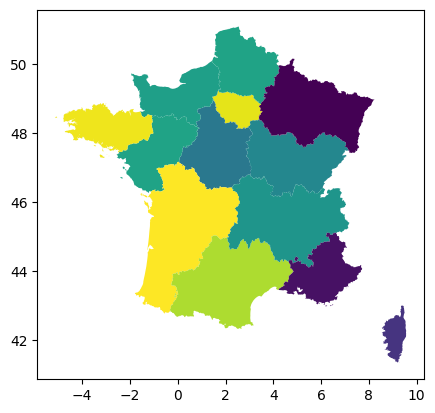

In [51]:
df = plot_referendum_map(result)

<Axes: >

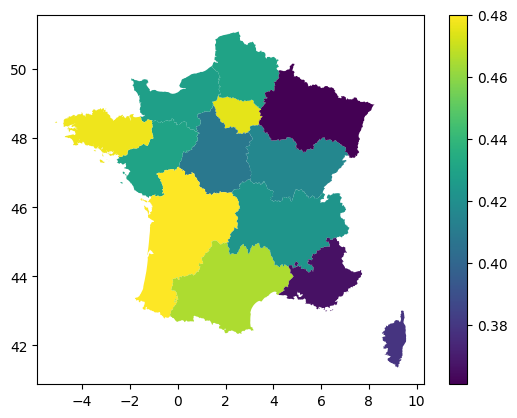

In [52]:
df.plot(column='ratio', legend=True)

In [ ]:
result['Choice A'] / pd.DataFrame.sum(result.loc[:, []])